# Problem 2

In [2]:
# Problem 2: Optimizers from Scratch

## 2.1 Optimizer Implementation

### **Imports and Device Configuration**


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

import time


In [3]:
# Determine the device

device = torch.device('cpu') # mps and cuda don't work 😭


In [4]:
# Define transformations: Convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define DataLoaders
batch_size = 64  # Initial batch size; will vary in 2.2

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# can't parallelize dataloader in juipternotebook the same way 🤧


In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels=1 for MNIST
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 Max pooling
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST
    
    def forward(self, x):
        # Convolutional layer 1
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Convolutional layer 2
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
class SGD_Momentum:
    def __init__(self, params, lr=0.01, beta=0.9):
        self.params = list(params)
        self.lr = lr
        self.beta = beta
        self.velocities = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    # Update velocity
                    self.velocities[i] = self.beta * self.velocities[i] + (1 - self.beta) * p.grad
                    # Update parameters
                    p.data -= self.lr * self.velocities[i]
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [7]:
class NAG:
    def __init__(self, params, lr=0.01, beta=0.95):
        self.params = list(params)
        self.lr = lr
        self.beta = beta
        self.velocities = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    prev_velocity = self.velocities[i]
                    # Update velocity
                    self.velocities[i] = self.beta * self.velocities[i] + p.grad
                    # Update parameters
                    p.data -= self.lr * (self.beta * prev_velocity + (1 - self.beta) * self.velocities[i])
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [8]:
class RMSprop:
    def __init__(self, params, lr=0.001, beta=0.95, gamma=1.0, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
        self.squares = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    # Update squared gradients
                    self.squares[i] = self.beta * self.squares[i] + (1 - self.beta) * (p.grad ** 2) 
                    # Update parameters
                    p.data -= self.lr * (p.grad / (self.squares[i].sqrt() + self.eps)) # this is RMS prop
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [9]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]
        self.t = 0  # Time step
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    # Update biased first moment estimate
                    self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                    # Update biased second moment estimate
                    self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)
                    # Compute bias-corrected first moment estimate
                    m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                    # Compute bias-corrected second moment estimate
                    v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                    # Update parameters
                    p.data -= self.lr * m_hat / (v_hat.sqrt() + self.eps) # this is adam
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [10]:
def train_model(model, train_loader, test_loader, optimizer, num_epochs=10, l1_lambda=1e-5): # l1_lambda for regulrization - aims towards sparsity

    # Loss function
    criterion = nn.CrossEntropyLoss() #since classification
    
    # Lists to store losses and accuracies so can plot later
    train_loss_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    model.to(device) # cpu or cuda or mps
    
    for epoch in range(num_epochs):
        model.train() # turn on train mode
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # L1 Regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
        
        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # L1 Regularization
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1_lambda * l1_norm
                
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_loss_history.append(avg_val_loss)
        
        val_accuracy = 100 * correct / total
        val_accuracy_history.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    return train_loss_history, val_loss_history, val_accuracy_history


### Boiler plate code to take all the runs

In [11]:
# Hyperparameters for Momentum - based on common values from the lit
learning_rate_momentum = 0.01
beta_momentum = 0.9
batch_size_momentum = 64  # because we go till 32 in 2.2 I thought we may aswell pick 64 - also 64 = ∞

# Define DataLoaders
train_loader_momentum = DataLoader(dataset=train_dataset, batch_size=batch_size_momentum, shuffle=True, num_workers=0)
test_loader_momentum = DataLoader(dataset=test_dataset, batch_size=batch_size_momentum, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_momentum = CNNModel()
optimizer_momentum = SGD_Momentum(model_momentum.parameters(), lr=learning_rate_momentum, beta=beta_momentum)

print("Training with Momentum Optimizer")
start_time = time.time()
train_loss_momentum, val_loss_momentum, val_acc_momentum = train_model(
    model_momentum, train_loader_momentum, test_loader_momentum, optimizer_momentum, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"Momentum Optimizer Training Time: {end_time - start_time:.2f} seconds")


Training with Momentum Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:19<00:00, 49.27batch/s, loss=0.168]


Epoch [1/10], Train Loss: 0.5816, Val Loss: 0.2501, Val Accuracy: 93.84%


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 56.11batch/s, loss=0.195] 


Epoch [2/10], Train Loss: 0.2073, Val Loss: 0.1631, Val Accuracy: 96.50%


Epoch 3/10: 100%|██████████| 938/938 [00:18<00:00, 51.01batch/s, loss=0.242] 


Epoch [3/10], Train Loss: 0.1509, Val Loss: 0.1426, Val Accuracy: 97.04%


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 56.17batch/s, loss=0.261] 


Epoch [4/10], Train Loss: 0.1258, Val Loss: 0.1133, Val Accuracy: 97.80%


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 56.37batch/s, loss=0.0594]


Epoch [5/10], Train Loss: 0.1107, Val Loss: 0.1008, Val Accuracy: 98.14%


Epoch 6/10: 100%|██████████| 938/938 [00:16<00:00, 56.44batch/s, loss=0.0662]


Epoch [6/10], Train Loss: 0.1017, Val Loss: 0.0967, Val Accuracy: 98.26%


Epoch 7/10: 100%|██████████| 938/938 [00:16<00:00, 56.08batch/s, loss=0.0586]


Epoch [7/10], Train Loss: 0.0949, Val Loss: 0.0905, Val Accuracy: 98.53%


Epoch 8/10: 100%|██████████| 938/938 [00:18<00:00, 52.08batch/s, loss=0.0505]


Epoch [8/10], Train Loss: 0.0903, Val Loss: 0.0872, Val Accuracy: 98.57%


Epoch 9/10: 100%|██████████| 938/938 [00:18<00:00, 50.52batch/s, loss=0.0463]


Epoch [9/10], Train Loss: 0.0853, Val Loss: 0.0848, Val Accuracy: 98.66%


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 57.20batch/s, loss=0.0925]


Epoch [10/10], Train Loss: 0.0815, Val Loss: 0.0837, Val Accuracy: 98.56%
Momentum Optimizer Training Time: 184.04 seconds


In [12]:
# Hyperparameters for NAG
learning_rate_nag = 0.01
beta_nag = 0.95
batch_size_nag = 64  

# Define DataLoaders
train_loader_nag = DataLoader(dataset=train_dataset, batch_size=batch_size_nag, shuffle=True, num_workers=0)
test_loader_nag = DataLoader(dataset=test_dataset, batch_size=batch_size_nag, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_nag = CNNModel()
optimizer_nag = NAG(model_nag.parameters(), lr=learning_rate_nag, beta=beta_nag)

print("\nTraining with Nesterov's Accelerated Gradient (NAG) Optimizer")
start_time = time.time()
train_loss_nag, val_loss_nag, val_acc_nag = train_model(
    model_nag, train_loader_nag, test_loader_nag, optimizer_nag, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"NAG Optimizer Training Time: {end_time - start_time:.2f} seconds")



Training with Nesterov's Accelerated Gradient (NAG) Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 57.55batch/s, loss=0.159] 


Epoch [1/10], Train Loss: 0.3404, Val Loss: 0.1092, Val Accuracy: 98.38%


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 57.71batch/s, loss=0.0533]


Epoch [2/10], Train Loss: 0.1027, Val Loss: 0.0923, Val Accuracy: 98.53%


Epoch 3/10: 100%|██████████| 938/938 [00:16<00:00, 57.82batch/s, loss=0.32]  


Epoch [3/10], Train Loss: 0.0819, Val Loss: 0.0776, Val Accuracy: 99.00%


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 57.75batch/s, loss=0.0722]


Epoch [4/10], Train Loss: 0.0706, Val Loss: 0.0797, Val Accuracy: 98.74%


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 57.66batch/s, loss=0.0519]


Epoch [5/10], Train Loss: 0.0606, Val Loss: 0.0723, Val Accuracy: 98.99%


Epoch 6/10: 100%|██████████| 938/938 [00:16<00:00, 57.53batch/s, loss=0.037] 


Epoch [6/10], Train Loss: 0.0536, Val Loss: 0.0748, Val Accuracy: 98.72%


Epoch 7/10: 100%|██████████| 938/938 [00:16<00:00, 57.81batch/s, loss=0.0416]


Epoch [7/10], Train Loss: 0.0489, Val Loss: 0.0597, Val Accuracy: 99.22%


Epoch 8/10: 100%|██████████| 938/938 [00:16<00:00, 57.89batch/s, loss=0.036] 


Epoch [8/10], Train Loss: 0.0434, Val Loss: 0.0606, Val Accuracy: 99.09%


Epoch 9/10: 100%|██████████| 938/938 [00:16<00:00, 56.95batch/s, loss=0.0307]


Epoch [9/10], Train Loss: 0.0402, Val Loss: 0.0638, Val Accuracy: 99.05%


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 58.05batch/s, loss=0.0297]


Epoch [10/10], Train Loss: 0.0386, Val Loss: 0.0647, Val Accuracy: 99.05%
NAG Optimizer Training Time: 172.31 seconds


In [13]:
# Hyperparameters for RMSprop
learning_rate_rmsprop = 0.001
beta_rmsprop = 0.95
gamma_rmsprop = 1.0
eps_rmsprop = 1e-8
batch_size_rmsprop = 64  

# Define DataLoaders
train_loader_rmsprop = DataLoader(dataset=train_dataset, batch_size=batch_size_rmsprop, shuffle=True, num_workers=0)
test_loader_rmsprop = DataLoader(dataset=test_dataset, batch_size=batch_size_rmsprop, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_rmsprop = CNNModel()
optimizer_rmsprop = RMSprop(model_rmsprop.parameters(), lr=learning_rate_rmsprop, beta=beta_rmsprop, gamma=gamma_rmsprop, eps=eps_rmsprop)

print("\nTraining with RMSprop Optimizer")
start_time = time.time()
train_loss_rmsprop, val_loss_rmsprop, val_acc_rmsprop = train_model(
    model_rmsprop, train_loader_rmsprop, test_loader_rmsprop, optimizer_rmsprop, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"RMSprop Optimizer Training Time: {end_time - start_time:.2f} seconds")



Training with RMSprop Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 58.06batch/s, loss=0.0558]


Epoch [1/10], Train Loss: 0.1592, Val Loss: 0.0739, Val Accuracy: 98.75%


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 58.36batch/s, loss=0.0668]


Epoch [2/10], Train Loss: 0.0768, Val Loss: 0.0733, Val Accuracy: 98.61%


Epoch 3/10: 100%|██████████| 938/938 [00:16<00:00, 56.77batch/s, loss=0.0339]


Epoch [3/10], Train Loss: 0.0630, Val Loss: 0.0569, Val Accuracy: 99.01%


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 58.17batch/s, loss=0.0309]


Epoch [4/10], Train Loss: 0.0553, Val Loss: 0.0554, Val Accuracy: 99.16%


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 57.74batch/s, loss=0.0266]


Epoch [5/10], Train Loss: 0.0500, Val Loss: 0.0550, Val Accuracy: 99.03%


Epoch 6/10: 100%|██████████| 938/938 [00:17<00:00, 53.42batch/s, loss=0.0468]


Epoch [6/10], Train Loss: 0.0469, Val Loss: 0.0579, Val Accuracy: 98.94%


Epoch 7/10: 100%|██████████| 938/938 [00:20<00:00, 45.27batch/s, loss=0.0279]


Epoch [7/10], Train Loss: 0.0435, Val Loss: 0.0563, Val Accuracy: 99.00%


Epoch 8/10: 100%|██████████| 938/938 [00:16<00:00, 55.35batch/s, loss=0.0251]


Epoch [8/10], Train Loss: 0.0414, Val Loss: 0.0522, Val Accuracy: 99.15%


Epoch 9/10: 100%|██████████| 938/938 [00:17<00:00, 52.72batch/s, loss=0.0234]


Epoch [9/10], Train Loss: 0.0390, Val Loss: 0.0533, Val Accuracy: 99.07%


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 55.64batch/s, loss=0.0227]


Epoch [10/10], Train Loss: 0.0371, Val Loss: 0.0524, Val Accuracy: 99.01%
RMSprop Optimizer Training Time: 182.37 seconds


In [42]:
# Hyperparameters for Adam
learning_rate_adam = 0.001 # usually the learning rate for Adam is taken low - unless doing dropout according to the lit
beta1_adam = 0.9
beta2_adam = 0.999
eps_adam = 1e-8
batch_size_adam = 64 

# Define DataLoaders
train_loader_adam = DataLoader(dataset=train_dataset, batch_size=batch_size_adam, shuffle=True, num_workers=0)
test_loader_adam = DataLoader(dataset=test_dataset, batch_size=batch_size_adam, shuffle=False, num_workers=0)

# Initialize model and optimizer
model_adam = CNNModel()
optimizer_adam = Adam(model_adam.parameters(), lr=learning_rate_adam, beta1=beta1_adam, beta2=beta2_adam, eps=eps_adam)

print("\nTraining with Adam Optimizer")
start_time = time.time()
train_loss_adam, val_loss_adam, val_acc_adam = train_model(
    model_adam, train_loader_adam, test_loader_adam, optimizer_adam, num_epochs=10, l1_lambda=1e-5)
end_time = time.time()
print(f"Adam Optimizer Training Time: {end_time - start_time:.2f} seconds")



Training with Adam Optimizer


Epoch 1/10: 100%|██████████| 938/938 [00:19<00:00, 47.36batch/s, loss=0.241] 


Epoch [1/10], Train Loss: 0.1748, Val Loss: 0.0882, Val Accuracy: 98.37%


Epoch 2/10: 100%|██████████| 938/938 [00:20<00:00, 45.49batch/s, loss=0.0448]


Epoch [2/10], Train Loss: 0.0833, Val Loss: 0.0930, Val Accuracy: 98.32%


Epoch 3/10: 100%|██████████| 938/938 [00:21<00:00, 43.88batch/s, loss=0.0515]


Epoch [3/10], Train Loss: 0.0714, Val Loss: 0.0838, Val Accuracy: 98.65%


Epoch 4/10: 100%|██████████| 938/938 [00:19<00:00, 47.20batch/s, loss=0.0463]


Epoch [4/10], Train Loss: 0.0667, Val Loss: 0.0694, Val Accuracy: 98.95%


Epoch 5/10: 100%|██████████| 938/938 [00:19<00:00, 48.37batch/s, loss=0.0566]


Epoch [5/10], Train Loss: 0.0614, Val Loss: 0.0653, Val Accuracy: 99.06%


Epoch 6/10: 100%|██████████| 938/938 [00:19<00:00, 47.99batch/s, loss=0.0475]


Epoch [6/10], Train Loss: 0.0575, Val Loss: 0.0831, Val Accuracy: 98.42%


Epoch 7/10: 100%|██████████| 938/938 [00:19<00:00, 48.33batch/s, loss=0.0626]


Epoch [7/10], Train Loss: 0.0534, Val Loss: 0.0642, Val Accuracy: 99.14%


Epoch 8/10: 100%|██████████| 938/938 [00:19<00:00, 48.41batch/s, loss=0.0809]


Epoch [8/10], Train Loss: 0.0498, Val Loss: 0.0697, Val Accuracy: 98.92%


Epoch 9/10: 100%|██████████| 938/938 [00:19<00:00, 48.23batch/s, loss=0.0465]


Epoch [9/10], Train Loss: 0.0482, Val Loss: 0.0602, Val Accuracy: 99.27%


Epoch 10/10: 100%|██████████| 938/938 [00:20<00:00, 46.38batch/s, loss=0.0392]


Epoch [10/10], Train Loss: 0.0454, Val Loss: 0.0702, Val Accuracy: 98.93%
Adam Optimizer Training Time: 210.82 seconds



Final Validation Accuracies:
Momentum Optimizer: 98.56%
NAG Optimizer: 99.05%
RMSprop Optimizer: 99.01%
Adam Optimizer: 99.06%


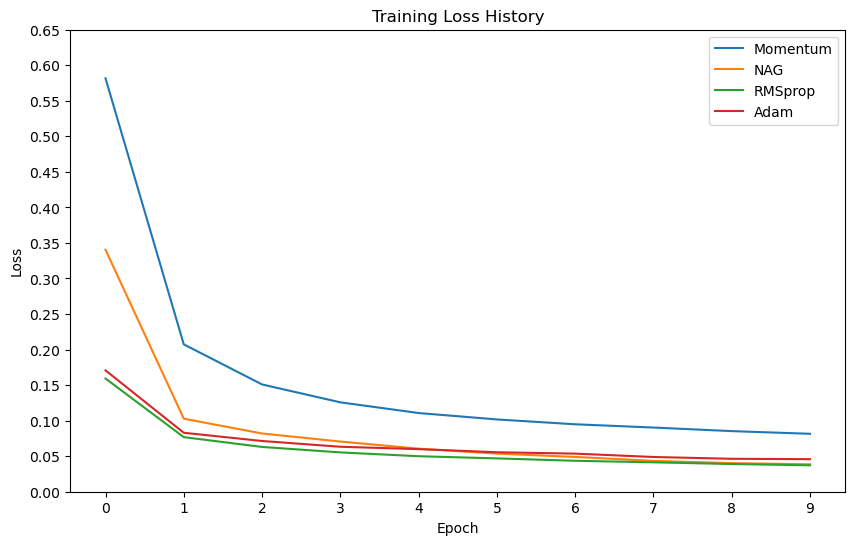

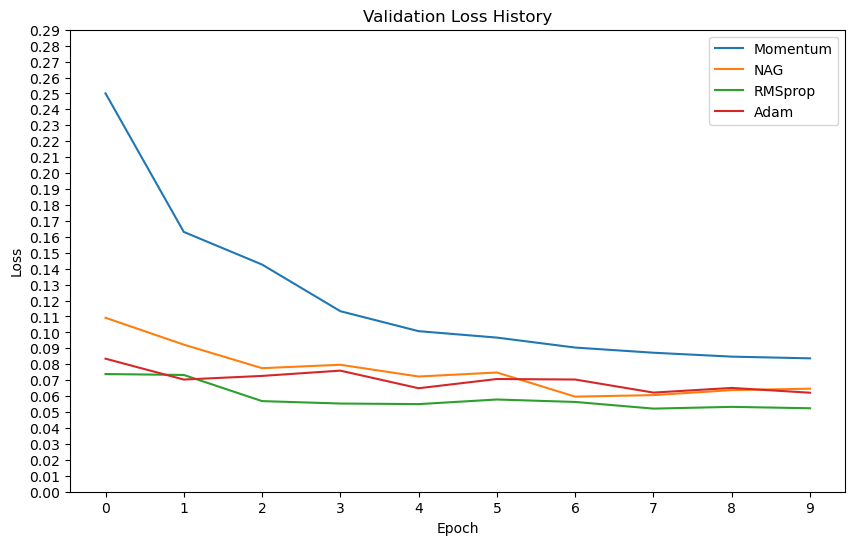

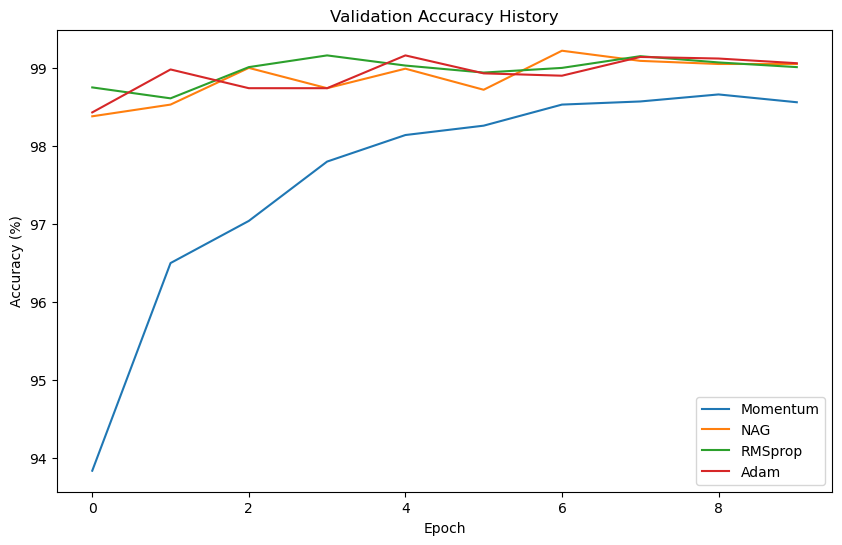

In [41]:
print("\nFinal Validation Accuracies:")

print(f"Momentum Optimizer: {val_acc_momentum[-1]:.2f}%")
print(f"NAG Optimizer: {val_acc_nag[-1]:.2f}%")
print(f"RMSprop Optimizer: {val_acc_rmsprop[-1]:.2f}%")
print(f"Adam Optimizer: {val_acc_adam[-1]:.2f}%")

# Plot training loss history

plt.figure(figsize=(10, 6))
plt.plot(train_loss_momentum, label='Momentum')
plt.plot(train_loss_nag, label='NAG')
plt.plot(train_loss_rmsprop, label='RMSprop')
plt.plot(train_loss_adam, label='Adam')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# x axis from 0 to 10
plt.xticks(np.arange(0, 10, 1))
# y axis from 0 to 0.7    
plt.yticks(np.arange(0, 0.7, 0.05))
plt.legend()
plt.show()


# Plot validation loss history

plt.figure(figsize=(10, 6))
plt.plot(val_loss_momentum, label='Momentum')
plt.plot(val_loss_nag, label='NAG')
plt.plot(val_loss_rmsprop, label='RMSprop')
plt.plot(val_loss_adam, label='Adam')
plt.title('Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# x axis from 0 to 10
plt.xticks(np.arange(0, 10, 1))
# y axis from 0 to 0.2
plt.yticks(np.arange(0, 0.3, 0.01))
plt.legend()
plt.show()


# plot accuracy history

plt.figure(figsize=(10, 6))
plt.plot(val_acc_momentum, label='Momentum')
plt.plot(val_acc_nag, label='NAG')
plt.plot(val_acc_rmsprop, label='RMSprop')
plt.plot(val_acc_adam, label='Adam')
plt.title('Validation Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


# 2.2

In [16]:
batch_sizes = [4, 8, 16, 32]

def compare_optimizers(optimizer_class, optimizer_name, batch_sizes, learning_rate, **kwargs):

    results = {} # a nested dictionary to store the results for each batch size
    for batch_size in batch_sizes:
        print(f"\nTraining with {optimizer_name}, Batch Size: {batch_size}")
        # Define DataLoaders
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        # Initialize model and optimizer
        model = CNNModel()
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, **kwargs)
        
        # Train the model
        train_loss, val_loss, val_acc = train_model(
            model, train_loader, test_loader, optimizer, num_epochs=10, l1_lambda=1e-5)
        
        # Store the results
        results[batch_size] = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        }
    return results


In [17]:
# Hyperparameters for Momentum
learning_rate_momentum = 0.01
beta_momentum = 0.9

momentum_results = compare_optimizers(
    optimizer_class=SGD_Momentum,
    optimizer_name="Momentum",
    batch_sizes=batch_sizes,
    learning_rate=learning_rate_momentum,
    beta=beta_momentum
)



Training with Momentum, Batch Size: 4


Epoch 1/10: 100%|██████████| 15000/15000 [00:46<00:00, 320.32batch/s, loss=0.0483]


Epoch [1/10], Train Loss: 0.1852, Val Loss: 0.0968, Val Accuracy: 98.34%


Epoch 2/10: 100%|██████████| 15000/15000 [00:48<00:00, 306.22batch/s, loss=0.0435]


Epoch [2/10], Train Loss: 0.0878, Val Loss: 0.0761, Val Accuracy: 98.81%


Epoch 3/10: 100%|██████████| 15000/15000 [00:50<00:00, 295.23batch/s, loss=0.0402]


Epoch [3/10], Train Loss: 0.0715, Val Loss: 0.0706, Val Accuracy: 98.93%


Epoch 4/10: 100%|██████████| 15000/15000 [00:42<00:00, 353.75batch/s, loss=0.0379]


Epoch [4/10], Train Loss: 0.0601, Val Loss: 0.0732, Val Accuracy: 98.78%


Epoch 5/10: 100%|██████████| 15000/15000 [00:41<00:00, 361.71batch/s, loss=0.0347]


Epoch [5/10], Train Loss: 0.0532, Val Loss: 0.0622, Val Accuracy: 99.05%


Epoch 6/10: 100%|██████████| 15000/15000 [00:41<00:00, 361.25batch/s, loss=0.25]  


Epoch [6/10], Train Loss: 0.0480, Val Loss: 0.0647, Val Accuracy: 98.95%


Epoch 7/10: 100%|██████████| 15000/15000 [00:42<00:00, 350.37batch/s, loss=0.0305]


Epoch [7/10], Train Loss: 0.0430, Val Loss: 0.0560, Val Accuracy: 99.26%


Epoch 8/10: 100%|██████████| 15000/15000 [00:48<00:00, 306.57batch/s, loss=0.029] 


Epoch [8/10], Train Loss: 0.0414, Val Loss: 0.0567, Val Accuracy: 99.23%


Epoch 9/10: 100%|██████████| 15000/15000 [00:48<00:00, 308.16batch/s, loss=0.0274]


Epoch [9/10], Train Loss: 0.0365, Val Loss: 0.0541, Val Accuracy: 99.21%


Epoch 10/10: 100%|██████████| 15000/15000 [00:46<00:00, 325.25batch/s, loss=0.0283]


Epoch [10/10], Train Loss: 0.0351, Val Loss: 0.0564, Val Accuracy: 99.14%

Training with Momentum, Batch Size: 8


Epoch 1/10: 100%|██████████| 7500/7500 [00:25<00:00, 288.94batch/s, loss=0.0461]


Epoch [1/10], Train Loss: 0.2241, Val Loss: 0.0983, Val Accuracy: 98.29%


Epoch 2/10: 100%|██████████| 7500/7500 [00:27<00:00, 273.73batch/s, loss=0.0539]


Epoch [2/10], Train Loss: 0.0978, Val Loss: 0.0901, Val Accuracy: 98.39%


Epoch 3/10: 100%|██████████| 7500/7500 [00:27<00:00, 277.02batch/s, loss=0.046] 


Epoch [3/10], Train Loss: 0.0800, Val Loss: 0.0773, Val Accuracy: 98.83%


Epoch 4/10: 100%|██████████| 7500/7500 [00:26<00:00, 285.85batch/s, loss=0.398] 


Epoch [4/10], Train Loss: 0.0710, Val Loss: 0.0666, Val Accuracy: 99.16%


Epoch 5/10: 100%|██████████| 7500/7500 [00:25<00:00, 289.55batch/s, loss=0.0638]


Epoch [5/10], Train Loss: 0.0626, Val Loss: 0.0669, Val Accuracy: 99.11%


Epoch 6/10: 100%|██████████| 7500/7500 [00:36<00:00, 204.97batch/s, loss=0.0377]


Epoch [6/10], Train Loss: 0.0566, Val Loss: 0.0618, Val Accuracy: 99.20%


Epoch 7/10: 100%|██████████| 7500/7500 [00:31<00:00, 240.66batch/s, loss=0.0734]


Epoch [7/10], Train Loss: 0.0526, Val Loss: 0.0613, Val Accuracy: 99.12%


Epoch 8/10: 100%|██████████| 7500/7500 [00:26<00:00, 279.40batch/s, loss=0.0355]


Epoch [8/10], Train Loss: 0.0487, Val Loss: 0.0605, Val Accuracy: 99.21%


Epoch 9/10: 100%|██████████| 7500/7500 [00:30<00:00, 249.93batch/s, loss=0.0334]


Epoch [9/10], Train Loss: 0.0451, Val Loss: 0.0587, Val Accuracy: 99.23%


Epoch 10/10: 100%|██████████| 7500/7500 [00:30<00:00, 242.66batch/s, loss=0.032] 


Epoch [10/10], Train Loss: 0.0423, Val Loss: 0.0610, Val Accuracy: 98.97%

Training with Momentum, Batch Size: 16


Epoch 1/10: 100%|██████████| 3750/3750 [00:25<00:00, 148.49batch/s, loss=0.051] 


Epoch [1/10], Train Loss: 0.3009, Val Loss: 0.1184, Val Accuracy: 97.77%


Epoch 2/10: 100%|██████████| 3750/3750 [00:27<00:00, 135.57batch/s, loss=0.113] 


Epoch [2/10], Train Loss: 0.1143, Val Loss: 0.1008, Val Accuracy: 98.21%


Epoch 3/10: 100%|██████████| 3750/3750 [00:26<00:00, 143.74batch/s, loss=0.0468]


Epoch [3/10], Train Loss: 0.0939, Val Loss: 0.0854, Val Accuracy: 98.58%


Epoch 4/10: 100%|██████████| 3750/3750 [00:25<00:00, 146.62batch/s, loss=0.116] 


Epoch [4/10], Train Loss: 0.0818, Val Loss: 0.0757, Val Accuracy: 98.83%


Epoch 5/10: 100%|██████████| 3750/3750 [00:25<00:00, 147.31batch/s, loss=0.0489]


Epoch [5/10], Train Loss: 0.0741, Val Loss: 0.0733, Val Accuracy: 98.85%


Epoch 6/10: 100%|██████████| 3750/3750 [00:30<00:00, 123.24batch/s, loss=0.0419]


Epoch [6/10], Train Loss: 0.0687, Val Loss: 0.0696, Val Accuracy: 98.96%


Epoch 7/10: 100%|██████████| 3750/3750 [00:34<00:00, 108.31batch/s, loss=0.0464]


Epoch [7/10], Train Loss: 0.0638, Val Loss: 0.0691, Val Accuracy: 99.01%


Epoch 8/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.67batch/s, loss=0.17]  


Epoch [8/10], Train Loss: 0.0595, Val Loss: 0.0659, Val Accuracy: 99.06%


Epoch 9/10: 100%|██████████| 3750/3750 [00:24<00:00, 152.25batch/s, loss=0.158] 


Epoch [9/10], Train Loss: 0.0554, Val Loss: 0.0677, Val Accuracy: 98.97%


Epoch 10/10: 100%|██████████| 3750/3750 [00:24<00:00, 151.22batch/s, loss=0.0433]


Epoch [10/10], Train Loss: 0.0535, Val Loss: 0.0696, Val Accuracy: 98.94%

Training with Momentum, Batch Size: 32


Epoch 1/10: 100%|██████████| 1875/1875 [00:19<00:00, 96.58batch/s, loss=0.0894] 


Epoch [1/10], Train Loss: 0.4033, Val Loss: 0.1424, Val Accuracy: 96.92%


Epoch 2/10: 100%|██████████| 1875/1875 [00:19<00:00, 95.70batch/s, loss=0.105]  


Epoch [2/10], Train Loss: 0.1364, Val Loss: 0.1085, Val Accuracy: 97.79%


Epoch 3/10: 100%|██████████| 1875/1875 [00:19<00:00, 97.02batch/s, loss=0.238]  


Epoch [3/10], Train Loss: 0.1115, Val Loss: 0.0997, Val Accuracy: 98.09%


Epoch 4/10: 100%|██████████| 1875/1875 [00:19<00:00, 95.95batch/s, loss=0.0733]


Epoch [4/10], Train Loss: 0.0980, Val Loss: 0.0882, Val Accuracy: 98.53%


Epoch 5/10: 100%|██████████| 1875/1875 [00:19<00:00, 97.41batch/s, loss=0.0497]


Epoch [5/10], Train Loss: 0.0893, Val Loss: 0.0892, Val Accuracy: 98.48%


Epoch 6/10: 100%|██████████| 1875/1875 [00:19<00:00, 97.08batch/s, loss=0.0557] 


Epoch [6/10], Train Loss: 0.0838, Val Loss: 0.0772, Val Accuracy: 98.76%


Epoch 7/10: 100%|██████████| 1875/1875 [00:20<00:00, 91.76batch/s, loss=0.0727] 


Epoch [7/10], Train Loss: 0.0779, Val Loss: 0.0780, Val Accuracy: 98.80%


Epoch 8/10: 100%|██████████| 1875/1875 [00:20<00:00, 92.62batch/s, loss=0.0956] 


Epoch [8/10], Train Loss: 0.0739, Val Loss: 0.0749, Val Accuracy: 98.76%


Epoch 9/10: 100%|██████████| 1875/1875 [00:19<00:00, 95.51batch/s, loss=0.0917] 


Epoch [9/10], Train Loss: 0.0703, Val Loss: 0.0709, Val Accuracy: 99.07%


Epoch 10/10: 100%|██████████| 1875/1875 [00:19<00:00, 95.88batch/s, loss=0.0742] 


Epoch [10/10], Train Loss: 0.0669, Val Loss: 0.0746, Val Accuracy: 98.85%


In [18]:
# Hyperparameters for NAG
learning_rate_nag = 0.01
beta_nag = 0.95

nag_results = compare_optimizers(
    optimizer_class=NAG,
    optimizer_name="Nesterov's Accelerated Gradient",
    batch_sizes=batch_sizes,
    learning_rate=learning_rate_nag,
    beta=beta_nag
)



Training with Nesterov's Accelerated Gradient, Batch Size: 4


Epoch 1/10: 100%|██████████| 15000/15000 [00:48<00:00, 311.61batch/s, loss=2.34] 


Epoch [1/10], Train Loss: 2.0455, Val Loss: 2.3749, Val Accuracy: 11.35%


Epoch 2/10: 100%|██████████| 15000/15000 [00:49<00:00, 305.81batch/s, loss=2.16]


Epoch [2/10], Train Loss: 2.3721, Val Loss: 2.3814, Val Accuracy: 10.09%


Epoch 3/10: 100%|██████████| 15000/15000 [00:53<00:00, 279.27batch/s, loss=2.34]


Epoch [3/10], Train Loss: 2.3596, Val Loss: 2.3484, Val Accuracy: 9.58%


Epoch 4/10: 100%|██████████| 15000/15000 [00:46<00:00, 325.39batch/s, loss=2.47]


Epoch [4/10], Train Loss: 2.3515, Val Loss: 2.3505, Val Accuracy: 11.35%


Epoch 5/10: 100%|██████████| 15000/15000 [00:44<00:00, 335.49batch/s, loss=2.41]


Epoch [5/10], Train Loss: 2.3455, Val Loss: 2.3330, Val Accuracy: 11.35%


Epoch 6/10: 100%|██████████| 15000/15000 [00:47<00:00, 318.76batch/s, loss=2.42]


Epoch [6/10], Train Loss: 2.3398, Val Loss: 2.3327, Val Accuracy: 10.32%


Epoch 7/10: 100%|██████████| 15000/15000 [00:50<00:00, 298.16batch/s, loss=2.4] 


Epoch [7/10], Train Loss: 2.3358, Val Loss: 2.3308, Val Accuracy: 9.74%


Epoch 8/10: 100%|██████████| 15000/15000 [00:48<00:00, 311.81batch/s, loss=2.46]


Epoch [8/10], Train Loss: 2.3331, Val Loss: 2.3345, Val Accuracy: 10.28%


Epoch 9/10: 100%|██████████| 15000/15000 [00:50<00:00, 297.13batch/s, loss=2.47]


Epoch [9/10], Train Loss: 2.3306, Val Loss: 2.3341, Val Accuracy: 10.28%


Epoch 10/10: 100%|██████████| 15000/15000 [00:45<00:00, 329.78batch/s, loss=2.28]


Epoch [10/10], Train Loss: 2.3293, Val Loss: 2.3232, Val Accuracy: 10.10%

Training with Nesterov's Accelerated Gradient, Batch Size: 8


Epoch 1/10: 100%|██████████| 7500/7500 [00:27<00:00, 273.79batch/s, loss=0.642] 


Epoch [1/10], Train Loss: 0.4403, Val Loss: 0.2340, Val Accuracy: 95.63%


Epoch 2/10: 100%|██████████| 7500/7500 [00:29<00:00, 254.38batch/s, loss=0.595] 


Epoch [2/10], Train Loss: 0.3249, Val Loss: 0.3205, Val Accuracy: 93.61%


Epoch 3/10: 100%|██████████| 7500/7500 [00:29<00:00, 256.53batch/s, loss=0.0809]


Epoch [3/10], Train Loss: 0.2981, Val Loss: 0.2985, Val Accuracy: 94.48%


Epoch 4/10: 100%|██████████| 7500/7500 [00:27<00:00, 274.91batch/s, loss=0.266] 


Epoch [4/10], Train Loss: 0.2792, Val Loss: 0.3458, Val Accuracy: 93.65%


Epoch 5/10: 100%|██████████| 7500/7500 [00:27<00:00, 274.01batch/s, loss=0.425] 


Epoch [5/10], Train Loss: 0.2697, Val Loss: 0.2984, Val Accuracy: 94.87%


Epoch 6/10: 100%|██████████| 7500/7500 [00:29<00:00, 253.17batch/s, loss=0.33]  


Epoch [6/10], Train Loss: 0.2731, Val Loss: 0.2917, Val Accuracy: 94.49%


Epoch 7/10: 100%|██████████| 7500/7500 [00:27<00:00, 271.24batch/s, loss=0.27]  


Epoch [7/10], Train Loss: 0.3347, Val Loss: 0.3313, Val Accuracy: 94.58%


Epoch 8/10: 100%|██████████| 7500/7500 [00:39<00:00, 190.68batch/s, loss=0.311] 


Epoch [8/10], Train Loss: 0.3593, Val Loss: 0.4718, Val Accuracy: 93.24%


Epoch 9/10: 100%|██████████| 7500/7500 [00:31<00:00, 236.33batch/s, loss=0.121] 


Epoch [9/10], Train Loss: 0.4399, Val Loss: 0.3631, Val Accuracy: 93.54%


Epoch 10/10: 100%|██████████| 7500/7500 [00:31<00:00, 237.57batch/s, loss=0.0913]


Epoch [10/10], Train Loss: 0.3175, Val Loss: 0.3566, Val Accuracy: 93.98%

Training with Nesterov's Accelerated Gradient, Batch Size: 16


Epoch 1/10: 100%|██████████| 3750/3750 [00:29<00:00, 128.30batch/s, loss=0.448] 


Epoch [1/10], Train Loss: 0.2829, Val Loss: 0.1510, Val Accuracy: 96.99%


Epoch 2/10: 100%|██████████| 3750/3750 [00:29<00:00, 129.30batch/s, loss=0.0436]


Epoch [2/10], Train Loss: 0.1269, Val Loss: 0.1137, Val Accuracy: 97.80%


Epoch 3/10: 100%|██████████| 3750/3750 [00:28<00:00, 129.51batch/s, loss=0.135] 


Epoch [3/10], Train Loss: 0.1060, Val Loss: 0.1129, Val Accuracy: 97.84%


Epoch 4/10: 100%|██████████| 3750/3750 [00:29<00:00, 126.90batch/s, loss=0.141] 


Epoch [4/10], Train Loss: 0.0971, Val Loss: 0.1051, Val Accuracy: 97.94%


Epoch 5/10: 100%|██████████| 3750/3750 [00:27<00:00, 134.05batch/s, loss=0.041] 


Epoch [5/10], Train Loss: 0.0937, Val Loss: 0.1243, Val Accuracy: 97.54%


Epoch 6/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.90batch/s, loss=0.0392]


Epoch [6/10], Train Loss: 0.0902, Val Loss: 0.1187, Val Accuracy: 98.00%


Epoch 7/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.82batch/s, loss=0.0569]


Epoch [7/10], Train Loss: 0.0878, Val Loss: 0.1013, Val Accuracy: 98.35%


Epoch 8/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.88batch/s, loss=0.0521]


Epoch [8/10], Train Loss: 0.0859, Val Loss: 0.1039, Val Accuracy: 98.25%


Epoch 9/10: 100%|██████████| 3750/3750 [00:27<00:00, 136.68batch/s, loss=0.0526]


Epoch [9/10], Train Loss: 0.0854, Val Loss: 0.1118, Val Accuracy: 98.34%


Epoch 10/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.75batch/s, loss=0.121] 


Epoch [10/10], Train Loss: 0.0859, Val Loss: 0.1405, Val Accuracy: 97.63%

Training with Nesterov's Accelerated Gradient, Batch Size: 32


Epoch 1/10: 100%|██████████| 1875/1875 [00:20<00:00, 92.23batch/s, loss=0.0698]


Epoch [1/10], Train Loss: 0.2410, Val Loss: 0.1042, Val Accuracy: 98.30%


Epoch 2/10: 100%|██████████| 1875/1875 [00:20<00:00, 92.55batch/s, loss=0.0988]


Epoch [2/10], Train Loss: 0.0958, Val Loss: 0.0798, Val Accuracy: 98.82%


Epoch 3/10: 100%|██████████| 1875/1875 [00:20<00:00, 91.49batch/s, loss=0.0397]


Epoch [3/10], Train Loss: 0.0751, Val Loss: 0.0881, Val Accuracy: 98.47%


Epoch 4/10: 100%|██████████| 1875/1875 [00:20<00:00, 92.40batch/s, loss=0.138] 


Epoch [4/10], Train Loss: 0.0640, Val Loss: 0.0688, Val Accuracy: 98.93%


Epoch 5/10: 100%|██████████| 1875/1875 [00:20<00:00, 91.88batch/s, loss=0.032] 


Epoch [5/10], Train Loss: 0.0553, Val Loss: 0.0656, Val Accuracy: 99.01%


Epoch 6/10: 100%|██████████| 1875/1875 [00:20<00:00, 92.55batch/s, loss=0.0501]


Epoch [6/10], Train Loss: 0.0501, Val Loss: 0.0647, Val Accuracy: 99.01%


Epoch 7/10: 100%|██████████| 1875/1875 [00:20<00:00, 91.22batch/s, loss=0.111] 


Epoch [7/10], Train Loss: 0.0484, Val Loss: 0.0702, Val Accuracy: 98.74%


Epoch 8/10: 100%|██████████| 1875/1875 [00:20<00:00, 91.24batch/s, loss=0.0299]


Epoch [8/10], Train Loss: 0.0455, Val Loss: 0.0710, Val Accuracy: 98.88%


Epoch 9/10: 100%|██████████| 1875/1875 [00:20<00:00, 91.58batch/s, loss=0.0293]


Epoch [9/10], Train Loss: 0.0429, Val Loss: 0.0668, Val Accuracy: 98.91%


Epoch 10/10: 100%|██████████| 1875/1875 [00:20<00:00, 90.68batch/s, loss=0.0282]


Epoch [10/10], Train Loss: 0.0407, Val Loss: 0.0712, Val Accuracy: 98.96%


In [19]:
# Hyperparameters for RMSprop
learning_rate_rmsprop = 0.001
beta_rmsprop = 0.95
gamma_rmsprop = 1.0
eps_rmsprop = 1e-8

rmsprop_results = compare_optimizers(
    optimizer_class=RMSprop,
    optimizer_name="RMSprop",
    batch_sizes=batch_sizes,
    learning_rate=learning_rate_rmsprop,
    beta=beta_rmsprop,
    gamma=gamma_rmsprop,
    eps=eps_rmsprop
)



Training with RMSprop, Batch Size: 4


Epoch 1/10: 100%|██████████| 15000/15000 [00:53<00:00, 279.22batch/s, loss=0.025] 


Epoch [1/10], Train Loss: 0.1413, Val Loss: 0.1290, Val Accuracy: 96.62%


Epoch 2/10: 100%|██████████| 15000/15000 [00:52<00:00, 288.04batch/s, loss=0.022] 


Epoch [2/10], Train Loss: 0.0909, Val Loss: 0.0770, Val Accuracy: 98.18%


Epoch 3/10: 100%|██████████| 15000/15000 [00:52<00:00, 287.83batch/s, loss=0.0393]


Epoch [3/10], Train Loss: 0.0829, Val Loss: 0.0681, Val Accuracy: 98.54%


Epoch 4/10: 100%|██████████| 15000/15000 [00:53<00:00, 282.30batch/s, loss=0.021] 


Epoch [4/10], Train Loss: 0.0801, Val Loss: 0.0747, Val Accuracy: 98.51%


Epoch 5/10: 100%|██████████| 15000/15000 [01:57<00:00, 127.52batch/s, loss=0.0194]


Epoch [5/10], Train Loss: 0.0780, Val Loss: 0.1040, Val Accuracy: 97.94%


Epoch 6/10: 100%|██████████| 15000/15000 [01:09<00:00, 214.89batch/s, loss=0.0197]


Epoch [6/10], Train Loss: 0.0767, Val Loss: 0.0809, Val Accuracy: 98.34%


Epoch 7/10: 100%|██████████| 15000/15000 [05:36<00:00, 44.57batch/s, loss=0.198]  


Epoch [7/10], Train Loss: 0.0764, Val Loss: 0.0861, Val Accuracy: 98.00%


Epoch 8/10: 100%|██████████| 15000/15000 [01:14<00:00, 200.14batch/s, loss=0.148] 


Epoch [8/10], Train Loss: 0.0770, Val Loss: 0.1064, Val Accuracy: 97.36%


Epoch 9/10: 100%|██████████| 15000/15000 [05:29<00:00, 45.57batch/s, loss=0.0791] 


Epoch [9/10], Train Loss: 0.0776, Val Loss: 0.0867, Val Accuracy: 98.23%


Epoch 10/10: 100%|██████████| 15000/15000 [03:53<00:00, 64.18batch/s, loss=0.0817] 


Epoch [10/10], Train Loss: 0.0770, Val Loss: 0.0766, Val Accuracy: 98.61%

Training with RMSprop, Batch Size: 8


Epoch 1/10: 100%|██████████| 7500/7500 [00:27<00:00, 268.62batch/s, loss=0.0913]


Epoch [1/10], Train Loss: 0.1375, Val Loss: 0.0758, Val Accuracy: 98.39%


Epoch 2/10: 100%|██████████| 7500/7500 [00:27<00:00, 276.03batch/s, loss=0.0324]


Epoch [2/10], Train Loss: 0.0830, Val Loss: 0.0710, Val Accuracy: 98.57%


Epoch 3/10: 100%|██████████| 7500/7500 [00:28<00:00, 267.56batch/s, loss=0.0285]


Epoch [3/10], Train Loss: 0.0730, Val Loss: 0.0961, Val Accuracy: 97.85%


Epoch 4/10: 100%|██████████| 7500/7500 [05:12<00:00, 24.03batch/s, loss=0.0233]  


Epoch [4/10], Train Loss: 0.0686, Val Loss: 0.0879, Val Accuracy: 98.16%


Epoch 5/10: 100%|██████████| 7500/7500 [06:04<00:00, 20.57batch/s, loss=0.0225]  


Epoch [5/10], Train Loss: 0.0645, Val Loss: 0.0695, Val Accuracy: 98.60%


Epoch 6/10: 100%|██████████| 7500/7500 [00:27<00:00, 272.63batch/s, loss=0.0725]


Epoch [6/10], Train Loss: 0.0627, Val Loss: 0.0628, Val Accuracy: 98.76%


Epoch 7/10: 100%|██████████| 7500/7500 [00:35<00:00, 210.58batch/s, loss=0.0196]


Epoch [7/10], Train Loss: 0.0600, Val Loss: 0.0610, Val Accuracy: 98.83%


Epoch 8/10: 100%|██████████| 7500/7500 [00:27<00:00, 275.46batch/s, loss=0.0206]


Epoch [8/10], Train Loss: 0.0590, Val Loss: 0.0636, Val Accuracy: 98.70%


Epoch 9/10: 100%|██████████| 7500/7500 [09:17<00:00, 13.46batch/s, loss=0.0244]  


Epoch [9/10], Train Loss: 0.0592, Val Loss: 0.0741, Val Accuracy: 98.47%


Epoch 10/10: 100%|██████████| 7500/7500 [17:32<00:00,  7.13batch/s, loss=0.0196]  


Epoch [10/10], Train Loss: 0.0581, Val Loss: 0.0656, Val Accuracy: 98.67%

Training with RMSprop, Batch Size: 16


Epoch 1/10: 100%|██████████| 3750/3750 [00:26<00:00, 140.16batch/s, loss=0.0735]


Epoch [1/10], Train Loss: 0.1357, Val Loss: 0.0727, Val Accuracy: 98.60%


Epoch 2/10: 100%|██████████| 3750/3750 [00:27<00:00, 138.47batch/s, loss=0.0361]


Epoch [2/10], Train Loss: 0.0756, Val Loss: 0.0616, Val Accuracy: 98.82%


Epoch 3/10: 100%|██████████| 3750/3750 [00:26<00:00, 141.37batch/s, loss=0.0241]


Epoch [3/10], Train Loss: 0.0638, Val Loss: 0.0669, Val Accuracy: 98.74%


Epoch 4/10: 100%|██████████| 3750/3750 [00:26<00:00, 142.21batch/s, loss=0.025] 


Epoch [4/10], Train Loss: 0.0570, Val Loss: 0.0630, Val Accuracy: 98.78%


Epoch 5/10: 100%|██████████| 3750/3750 [00:26<00:00, 139.22batch/s, loss=0.0265]


Epoch [5/10], Train Loss: 0.0536, Val Loss: 0.0550, Val Accuracy: 98.89%


Epoch 6/10: 100%|██████████| 3750/3750 [00:27<00:00, 137.44batch/s, loss=0.0223]


Epoch [6/10], Train Loss: 0.0509, Val Loss: 0.0554, Val Accuracy: 98.88%


Epoch 7/10: 100%|██████████| 3750/3750 [12:39<00:00,  4.94batch/s, loss=0.0215]  


Epoch [7/10], Train Loss: 0.0484, Val Loss: 0.0550, Val Accuracy: 98.93%


Epoch 8/10: 100%|██████████| 3750/3750 [00:26<00:00, 142.65batch/s, loss=0.0213]


Epoch [8/10], Train Loss: 0.0483, Val Loss: 0.0557, Val Accuracy: 98.93%


Epoch 9/10: 100%|██████████| 3750/3750 [00:25<00:00, 144.46batch/s, loss=0.0204]


Epoch [9/10], Train Loss: 0.0459, Val Loss: 0.0591, Val Accuracy: 98.84%


Epoch 10/10: 100%|██████████| 3750/3750 [00:25<00:00, 145.53batch/s, loss=0.0204]


Epoch [10/10], Train Loss: 0.0447, Val Loss: 0.0639, Val Accuracy: 98.85%

Training with RMSprop, Batch Size: 32


Epoch 1/10: 100%|██████████| 1875/1875 [00:19<00:00, 95.96batch/s, loss=0.186] 


Epoch [1/10], Train Loss: 0.1544, Val Loss: 0.0728, Val Accuracy: 98.70%


Epoch 2/10: 100%|██████████| 1875/1875 [00:20<00:00, 93.56batch/s, loss=0.0347]


Epoch [2/10], Train Loss: 0.0764, Val Loss: 0.0638, Val Accuracy: 98.91%


Epoch 3/10: 100%|██████████| 1875/1875 [00:20<00:00, 92.27batch/s, loss=0.092] 


Epoch [3/10], Train Loss: 0.0656, Val Loss: 0.0619, Val Accuracy: 98.90%


Epoch 4/10: 100%|██████████| 1875/1875 [00:20<00:00, 90.73batch/s, loss=0.0328]


Epoch [4/10], Train Loss: 0.0591, Val Loss: 0.0641, Val Accuracy: 98.89%


Epoch 5/10: 100%|██████████| 1875/1875 [00:21<00:00, 88.78batch/s, loss=0.0563]


Epoch [5/10], Train Loss: 0.0537, Val Loss: 0.0675, Val Accuracy: 98.65%


Epoch 6/10: 100%|██████████| 1875/1875 [00:21<00:00, 88.55batch/s, loss=0.045] 


Epoch [6/10], Train Loss: 0.0506, Val Loss: 0.0577, Val Accuracy: 99.14%


Epoch 7/10: 100%|██████████| 1875/1875 [00:21<00:00, 87.37batch/s, loss=0.0255]


Epoch [7/10], Train Loss: 0.0476, Val Loss: 0.0539, Val Accuracy: 99.20%


Epoch 8/10: 100%|██████████| 1875/1875 [00:21<00:00, 85.73batch/s, loss=0.0257]


Epoch [8/10], Train Loss: 0.0457, Val Loss: 0.0559, Val Accuracy: 99.11%


Epoch 9/10: 100%|██████████| 1875/1875 [00:22<00:00, 85.02batch/s, loss=0.0316]


Epoch [9/10], Train Loss: 0.0440, Val Loss: 0.0557, Val Accuracy: 99.03%


Epoch 10/10: 100%|██████████| 1875/1875 [00:22<00:00, 84.09batch/s, loss=0.0377]


Epoch [10/10], Train Loss: 0.0422, Val Loss: 0.0573, Val Accuracy: 99.13%


In [20]:
# Hyperparameters for Adam
learning_rate_adam = 0.001
beta1_adam = 0.9
beta2_adam = 0.999
eps_adam = 1e-8

adam_results = compare_optimizers(
    optimizer_class=Adam,
    optimizer_name="Adam",
    batch_sizes=batch_sizes,
    learning_rate=learning_rate_adam,
    beta1=beta1_adam,
    beta2=beta2_adam,
    eps=eps_adam
)



Training with Adam, Batch Size: 4


Epoch 1/10: 100%|██████████| 15000/15000 [01:03<00:00, 234.78batch/s, loss=0.09]  


Epoch [1/10], Train Loss: 0.1596, Val Loss: 0.1158, Val Accuracy: 98.26%


Epoch 2/10: 100%|██████████| 15000/15000 [01:05<00:00, 228.88batch/s, loss=0.0588]


Epoch [2/10], Train Loss: 0.1028, Val Loss: 0.0927, Val Accuracy: 98.67%


Epoch 3/10: 100%|██████████| 15000/15000 [01:05<00:00, 230.42batch/s, loss=0.0517]


Epoch [3/10], Train Loss: 0.0891, Val Loss: 0.1086, Val Accuracy: 98.40%


Epoch 4/10: 100%|██████████| 15000/15000 [01:05<00:00, 229.01batch/s, loss=0.0657]


Epoch [4/10], Train Loss: 0.0807, Val Loss: 0.0892, Val Accuracy: 98.77%


Epoch 5/10: 100%|██████████| 15000/15000 [01:05<00:00, 230.10batch/s, loss=0.0434]


Epoch [5/10], Train Loss: 0.0737, Val Loss: 0.0771, Val Accuracy: 98.93%


Epoch 6/10: 100%|██████████| 15000/15000 [01:05<00:00, 228.55batch/s, loss=0.0431]


Epoch [6/10], Train Loss: 0.0698, Val Loss: 0.0759, Val Accuracy: 99.00%


Epoch 7/10: 100%|██████████| 15000/15000 [01:05<00:00, 227.81batch/s, loss=0.0399]


Epoch [7/10], Train Loss: 0.0662, Val Loss: 0.0791, Val Accuracy: 98.86%


Epoch 8/10: 100%|██████████| 15000/15000 [01:05<00:00, 228.63batch/s, loss=0.0396]


Epoch [8/10], Train Loss: 0.0636, Val Loss: 0.0873, Val Accuracy: 98.78%


Epoch 9/10: 100%|██████████| 15000/15000 [01:06<00:00, 226.74batch/s, loss=0.039] 


Epoch [9/10], Train Loss: 0.0639, Val Loss: 0.0839, Val Accuracy: 98.71%


Epoch 10/10: 100%|██████████| 15000/15000 [01:06<00:00, 226.31batch/s, loss=0.0391]


Epoch [10/10], Train Loss: 0.0612, Val Loss: 0.0813, Val Accuracy: 98.76%

Training with Adam, Batch Size: 8


Epoch 1/10: 100%|██████████| 7500/7500 [01:04<00:00, 116.48batch/s, loss=0.0914]


Epoch [1/10], Train Loss: 0.1529, Val Loss: 0.1039, Val Accuracy: 98.46%


Epoch 2/10: 100%|██████████| 7500/7500 [00:42<00:00, 175.90batch/s, loss=0.0716]


Epoch [2/10], Train Loss: 0.0976, Val Loss: 0.0878, Val Accuracy: 98.81%


Epoch 3/10: 100%|██████████| 7500/7500 [00:37<00:00, 198.31batch/s, loss=0.0497]


Epoch [3/10], Train Loss: 0.0821, Val Loss: 0.0816, Val Accuracy: 98.98%


Epoch 4/10: 100%|██████████| 7500/7500 [00:37<00:00, 198.40batch/s, loss=0.046] 


Epoch [4/10], Train Loss: 0.0758, Val Loss: 0.0765, Val Accuracy: 98.98%


Epoch 5/10: 100%|██████████| 7500/7500 [00:38<00:00, 194.00batch/s, loss=0.044] 


Epoch [5/10], Train Loss: 0.0684, Val Loss: 0.1107, Val Accuracy: 98.08%


Epoch 6/10: 100%|██████████| 7500/7500 [00:39<00:00, 188.77batch/s, loss=0.0453]


Epoch [6/10], Train Loss: 0.0648, Val Loss: 0.0753, Val Accuracy: 99.02%


Epoch 7/10: 100%|██████████| 7500/7500 [00:41<00:00, 181.84batch/s, loss=0.13]  


Epoch [7/10], Train Loss: 0.0609, Val Loss: 0.0723, Val Accuracy: 99.09%


Epoch 8/10: 100%|██████████| 7500/7500 [00:42<00:00, 174.66batch/s, loss=0.0399]


Epoch [8/10], Train Loss: 0.0576, Val Loss: 0.0763, Val Accuracy: 98.96%


Epoch 9/10: 100%|██████████| 7500/7500 [00:44<00:00, 169.50batch/s, loss=0.0392]


Epoch [9/10], Train Loss: 0.0569, Val Loss: 0.0748, Val Accuracy: 98.88%


Epoch 10/10: 100%|██████████| 7500/7500 [00:45<00:00, 166.30batch/s, loss=0.0382]


Epoch [10/10], Train Loss: 0.0534, Val Loss: 0.0722, Val Accuracy: 98.88%

Training with Adam, Batch Size: 16


Epoch 1/10: 100%|██████████| 3750/3750 [00:39<00:00, 94.62batch/s, loss=0.0489]


Epoch [1/10], Train Loss: 0.1511, Val Loss: 0.0930, Val Accuracy: 98.55%


Epoch 2/10: 100%|██████████| 3750/3750 [00:39<00:00, 94.95batch/s, loss=0.196] 


Epoch [2/10], Train Loss: 0.0939, Val Loss: 0.0887, Val Accuracy: 98.71%


Epoch 3/10: 100%|██████████| 3750/3750 [00:38<00:00, 96.74batch/s, loss=0.0482] 


Epoch [3/10], Train Loss: 0.0804, Val Loss: 0.0918, Val Accuracy: 98.64%


Epoch 4/10: 100%|██████████| 3750/3750 [00:38<00:00, 98.14batch/s, loss=0.046]  


Epoch [4/10], Train Loss: 0.0724, Val Loss: 0.0728, Val Accuracy: 99.10%


Epoch 5/10: 100%|██████████| 3750/3750 [00:37<00:00, 99.56batch/s, loss=0.157]  


Epoch [5/10], Train Loss: 0.0644, Val Loss: 0.0792, Val Accuracy: 98.90%


Epoch 6/10: 100%|██████████| 3750/3750 [00:37<00:00, 100.09batch/s, loss=0.0898]


Epoch [6/10], Train Loss: 0.0594, Val Loss: 0.0901, Val Accuracy: 98.49%


Epoch 7/10: 100%|██████████| 3750/3750 [00:37<00:00, 101.15batch/s, loss=0.0477]


Epoch [7/10], Train Loss: 0.0566, Val Loss: 0.0744, Val Accuracy: 99.03%


Epoch 8/10: 100%|██████████| 3750/3750 [00:37<00:00, 101.26batch/s, loss=0.0397]


Epoch [8/10], Train Loss: 0.0533, Val Loss: 0.0734, Val Accuracy: 98.99%


Epoch 9/10: 100%|██████████| 3750/3750 [00:36<00:00, 101.73batch/s, loss=0.0367]


Epoch [9/10], Train Loss: 0.0514, Val Loss: 0.0701, Val Accuracy: 99.06%


Epoch 10/10: 100%|██████████| 3750/3750 [00:36<00:00, 101.48batch/s, loss=0.041] 


Epoch [10/10], Train Loss: 0.0501, Val Loss: 0.0657, Val Accuracy: 99.04%

Training with Adam, Batch Size: 32


Epoch 1/10: 100%|██████████| 1875/1875 [00:27<00:00, 67.62batch/s, loss=0.0583]


Epoch [1/10], Train Loss: 0.1538, Val Loss: 0.0827, Val Accuracy: 98.60%


Epoch 2/10: 100%|██████████| 1875/1875 [00:27<00:00, 67.16batch/s, loss=0.0721]


Epoch [2/10], Train Loss: 0.0850, Val Loss: 0.0778, Val Accuracy: 98.89%


Epoch 3/10: 100%|██████████| 1875/1875 [00:28<00:00, 66.83batch/s, loss=0.047] 


Epoch [3/10], Train Loss: 0.0749, Val Loss: 0.0675, Val Accuracy: 99.15%


Epoch 4/10: 100%|██████████| 1875/1875 [00:28<00:00, 66.50batch/s, loss=0.043] 


Epoch [4/10], Train Loss: 0.0662, Val Loss: 0.0682, Val Accuracy: 99.15%


Epoch 5/10: 100%|██████████| 1875/1875 [00:28<00:00, 66.45batch/s, loss=0.043] 


Epoch [5/10], Train Loss: 0.0592, Val Loss: 0.0686, Val Accuracy: 99.02%


Epoch 6/10: 100%|██████████| 1875/1875 [00:28<00:00, 66.09batch/s, loss=0.0422]


Epoch [6/10], Train Loss: 0.0575, Val Loss: 0.0727, Val Accuracy: 99.01%


Epoch 7/10: 100%|██████████| 1875/1875 [00:28<00:00, 65.98batch/s, loss=0.0767]


Epoch [7/10], Train Loss: 0.0525, Val Loss: 0.0758, Val Accuracy: 98.80%


Epoch 8/10: 100%|██████████| 1875/1875 [00:28<00:00, 65.52batch/s, loss=0.0413]


Epoch [8/10], Train Loss: 0.0499, Val Loss: 0.0612, Val Accuracy: 99.33%


Epoch 9/10: 100%|██████████| 1875/1875 [00:28<00:00, 64.97batch/s, loss=0.0669]


Epoch [9/10], Train Loss: 0.0484, Val Loss: 0.0638, Val Accuracy: 99.13%


Epoch 10/10: 100%|██████████| 1875/1875 [00:28<00:00, 65.03batch/s, loss=0.046] 


Epoch [10/10], Train Loss: 0.0448, Val Loss: 0.0644, Val Accuracy: 99.12%


In [21]:
def plot_results(optimizer_results, optimizer_name):
    for batch_size, result in optimizer_results.items():
        epochs = range(1, len(result['train_loss']) + 1)
        plt.figure(figsize=(12, 5))
        
        # Plot Training and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, result['train_loss'], 'b-', label='Training Loss')
        plt.plot(epochs, result['val_loss'], 'r-', label='Validation Loss')
        plt.title(f'{optimizer_name} - Batch Size {batch_size}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, result['val_accuracy'], 'g-', label='Validation Accuracy')
        plt.title(f'{optimizer_name} - Batch Size {batch_size}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()



Plotting Results for Momentum Optimizer


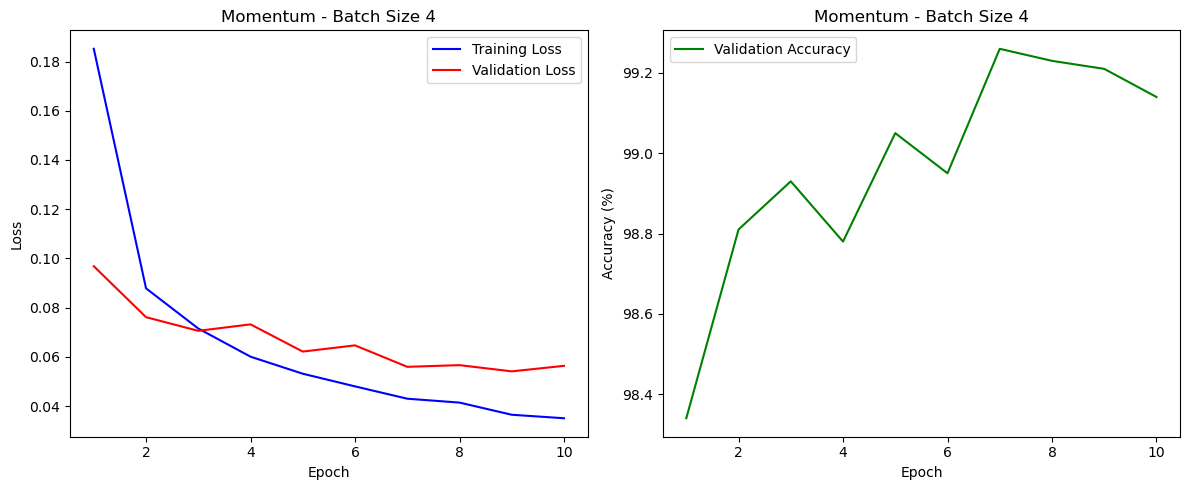

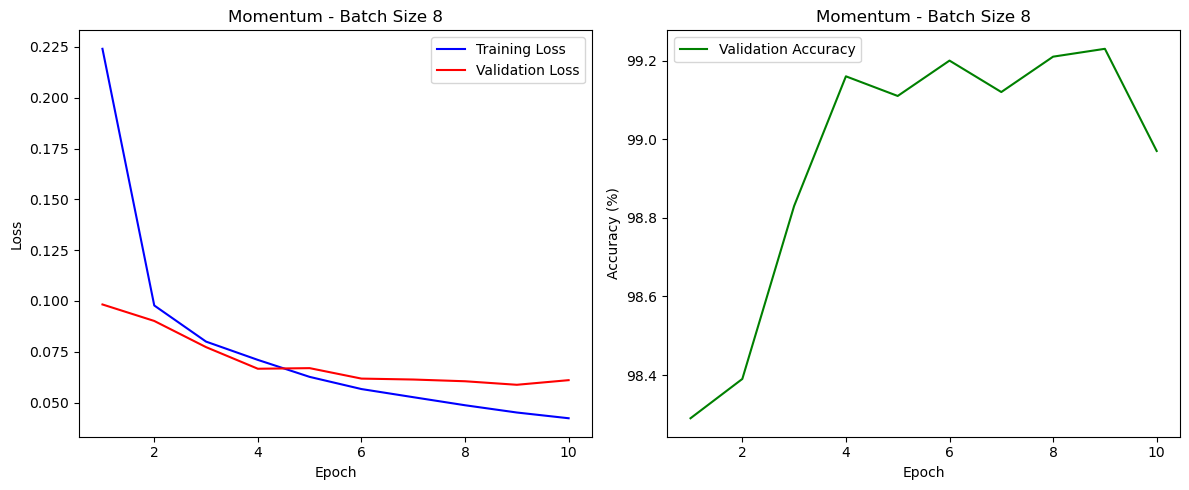

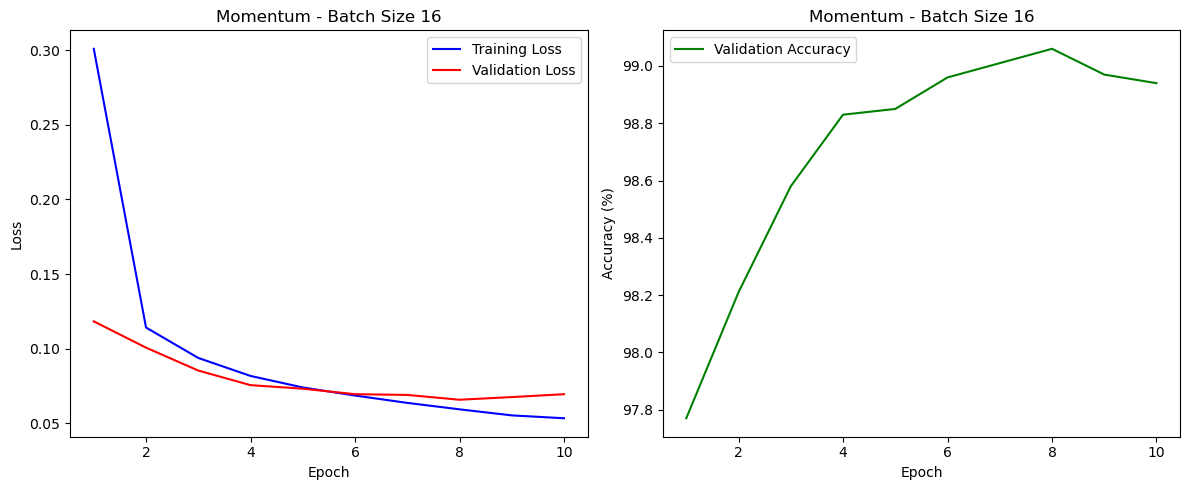

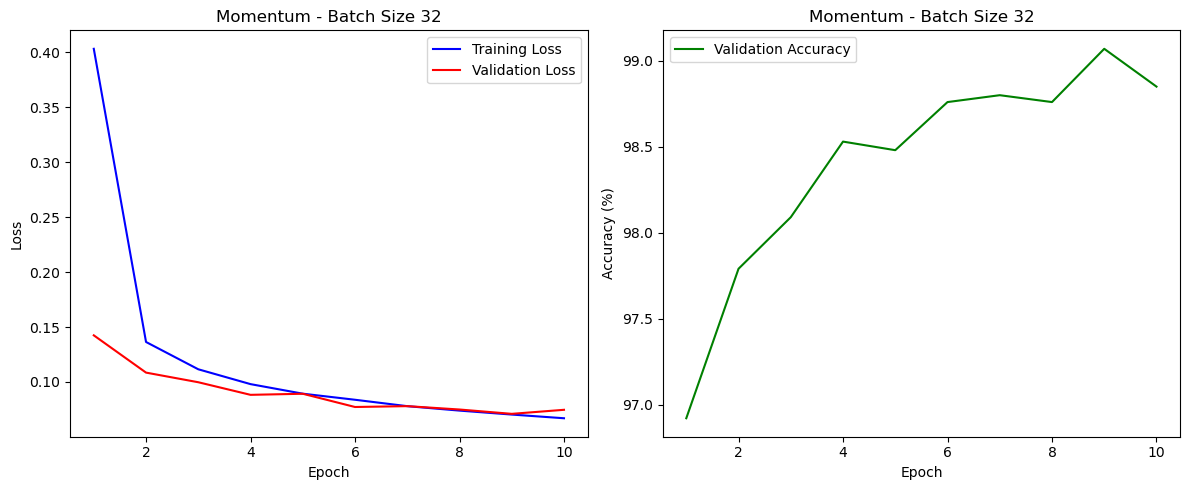


Plotting Results for Nesterov's Accelerated Gradient Optimizer


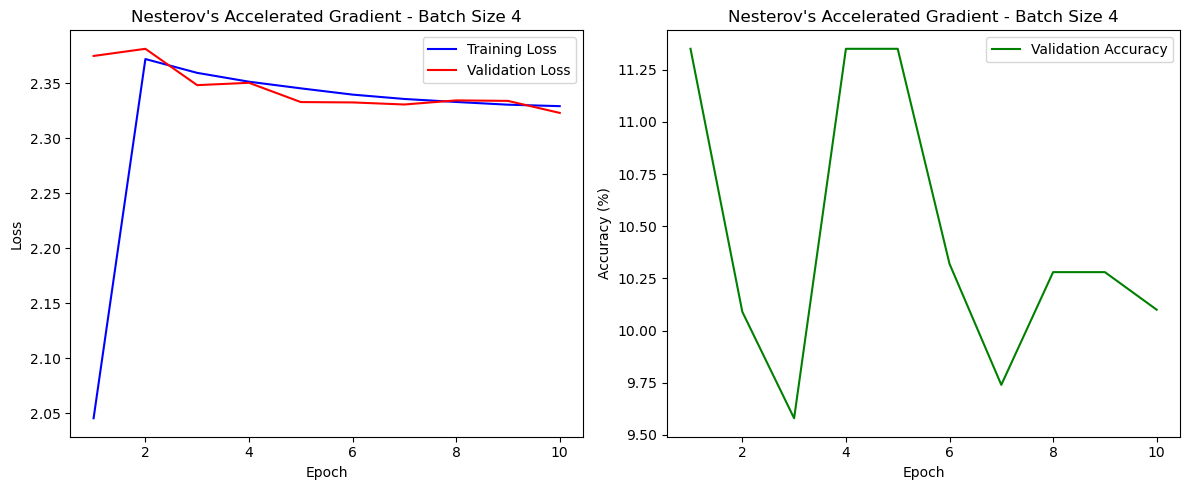

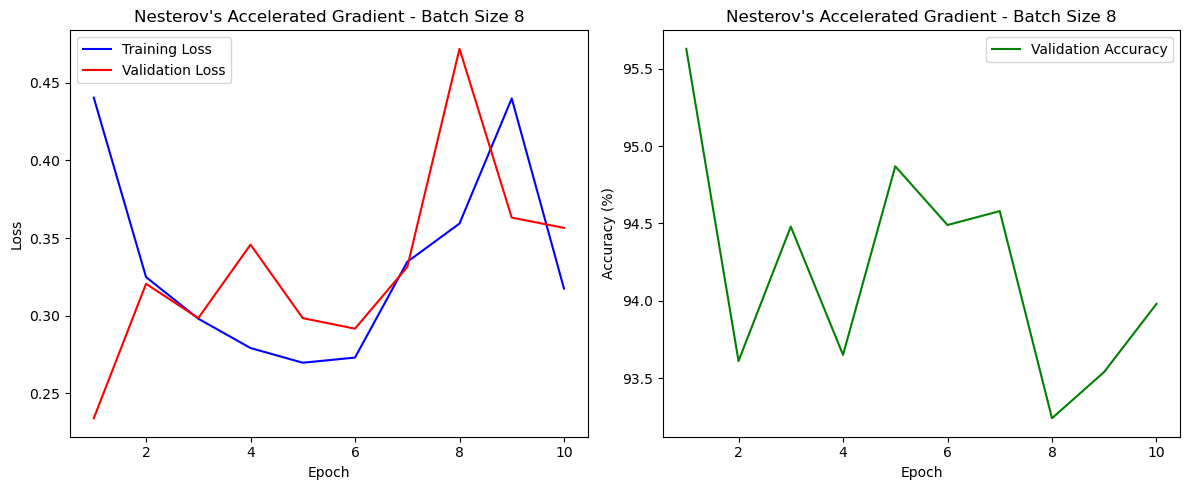

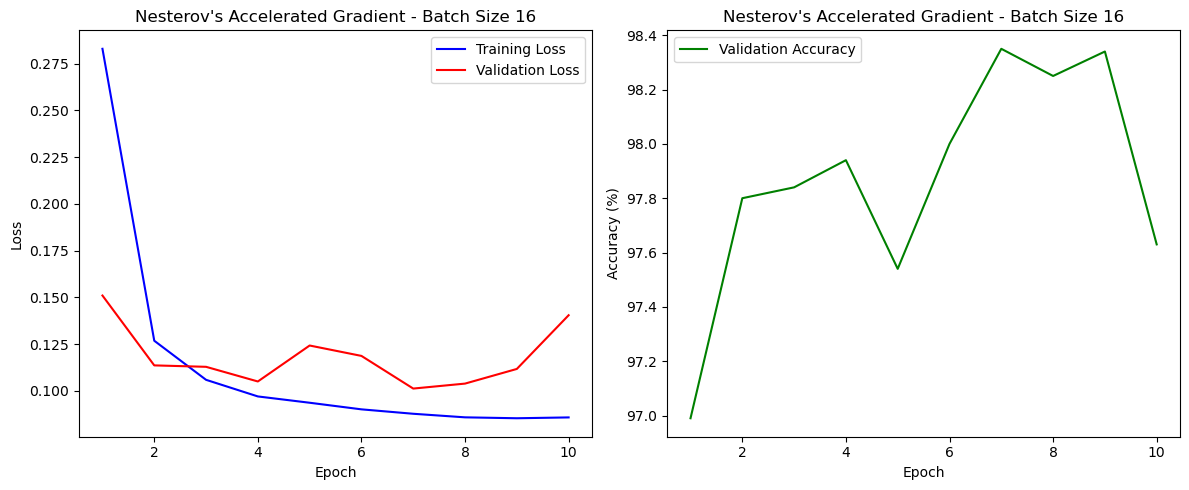

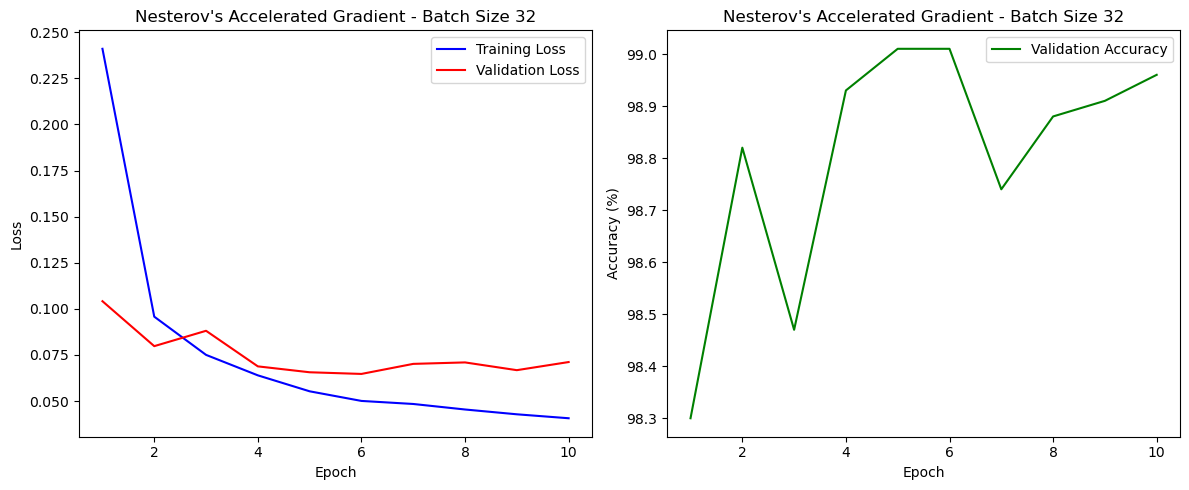


Plotting Results for RMSprop Optimizer


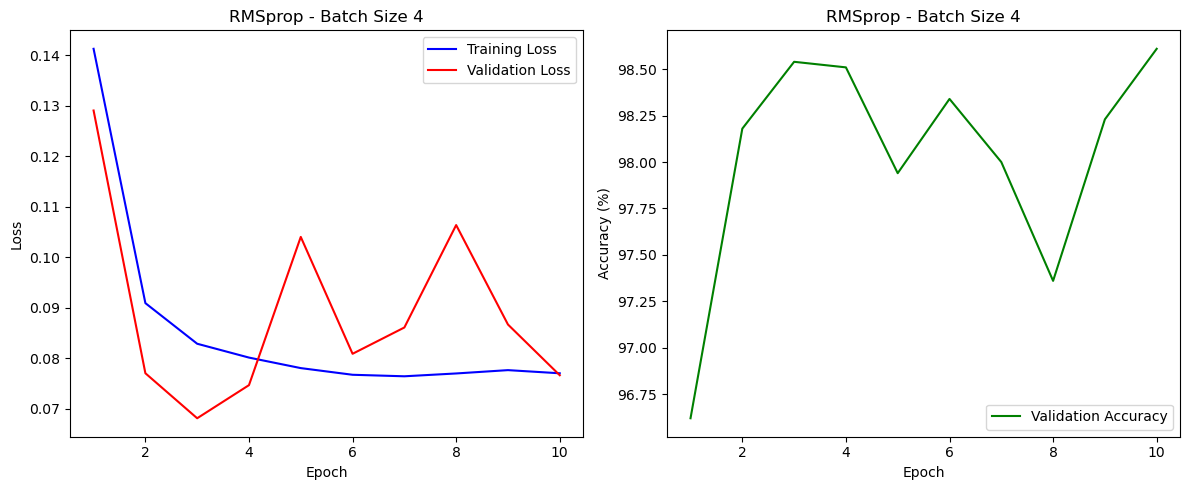

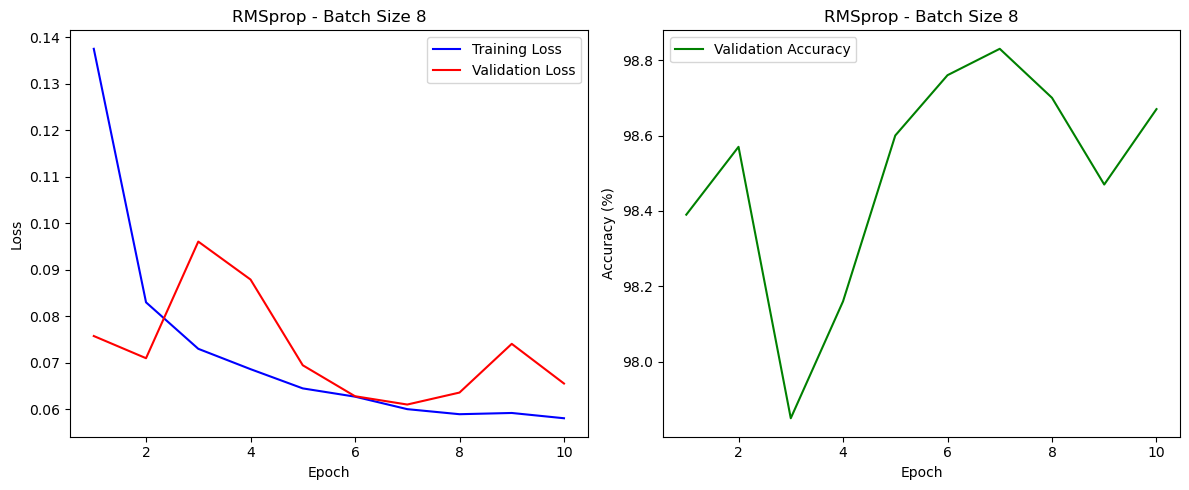

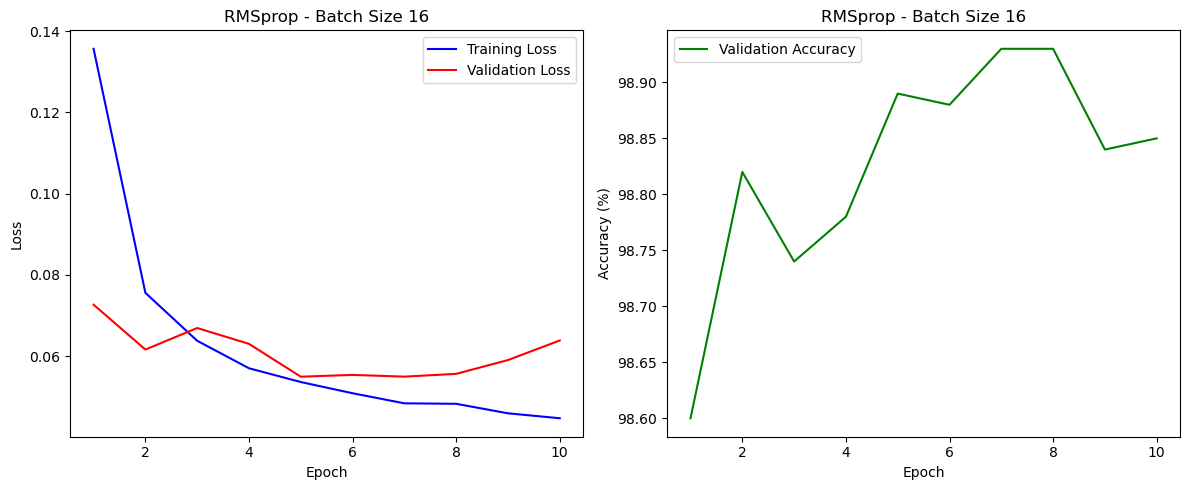

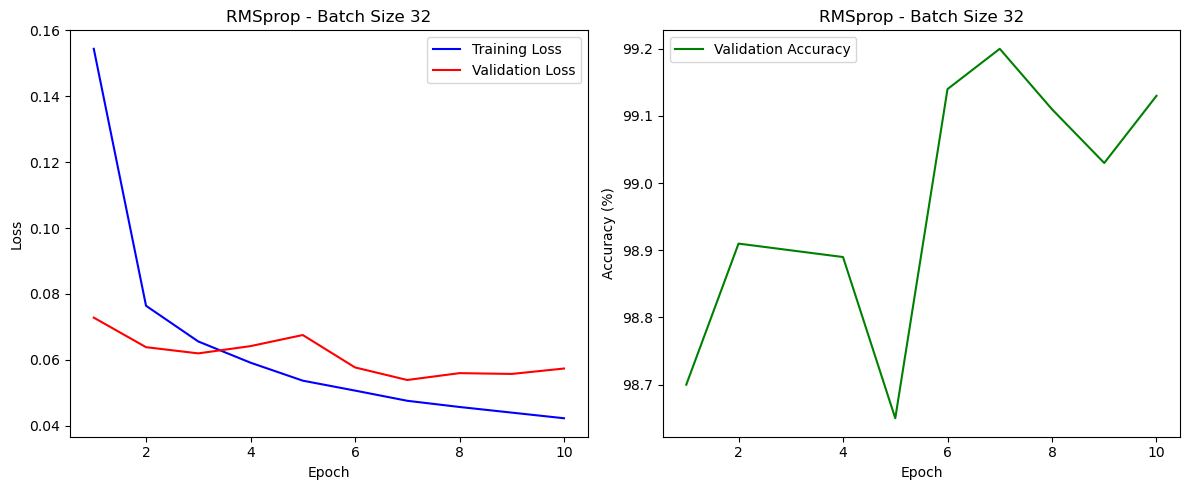


Plotting Results for Adam Optimizer


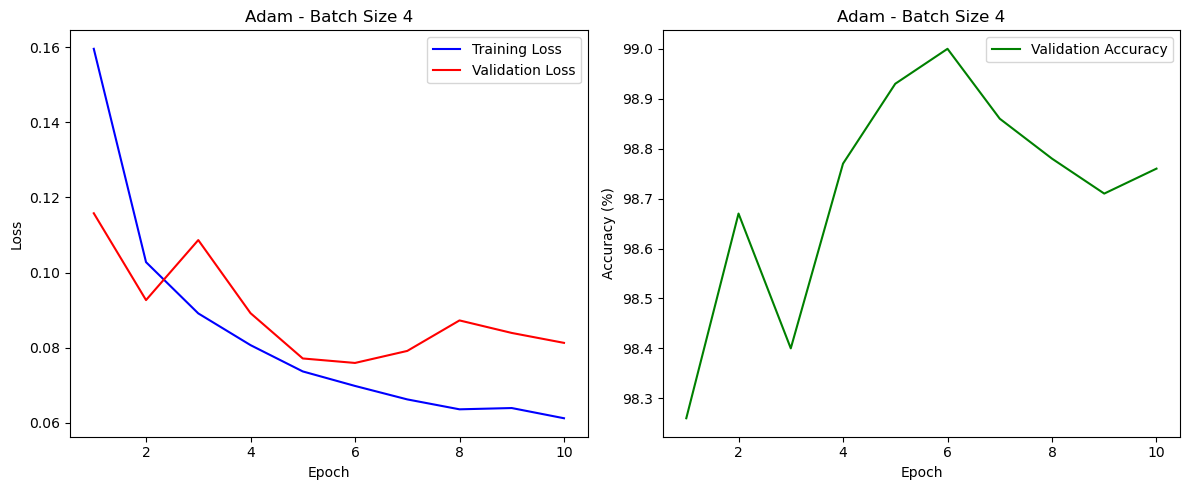

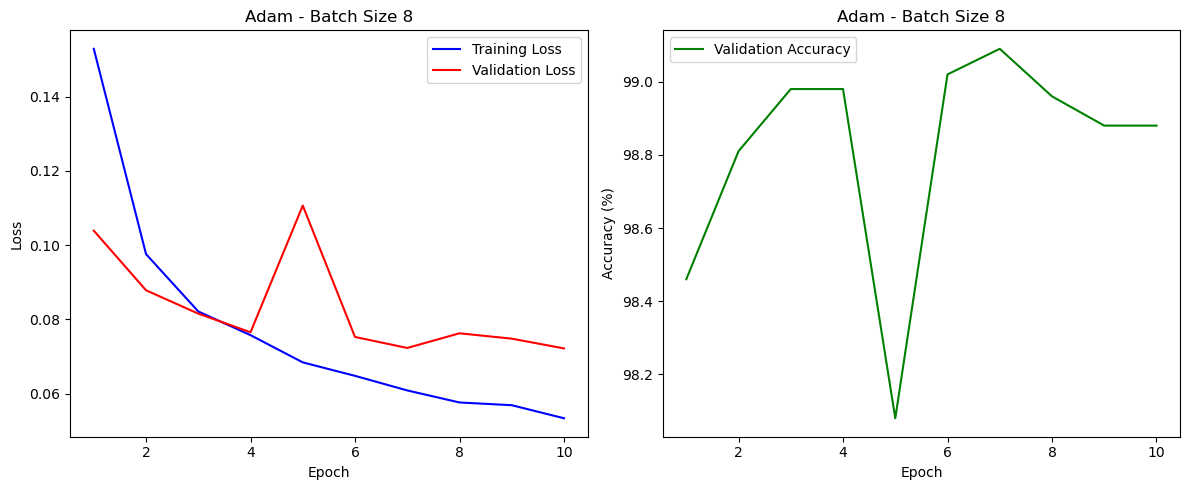

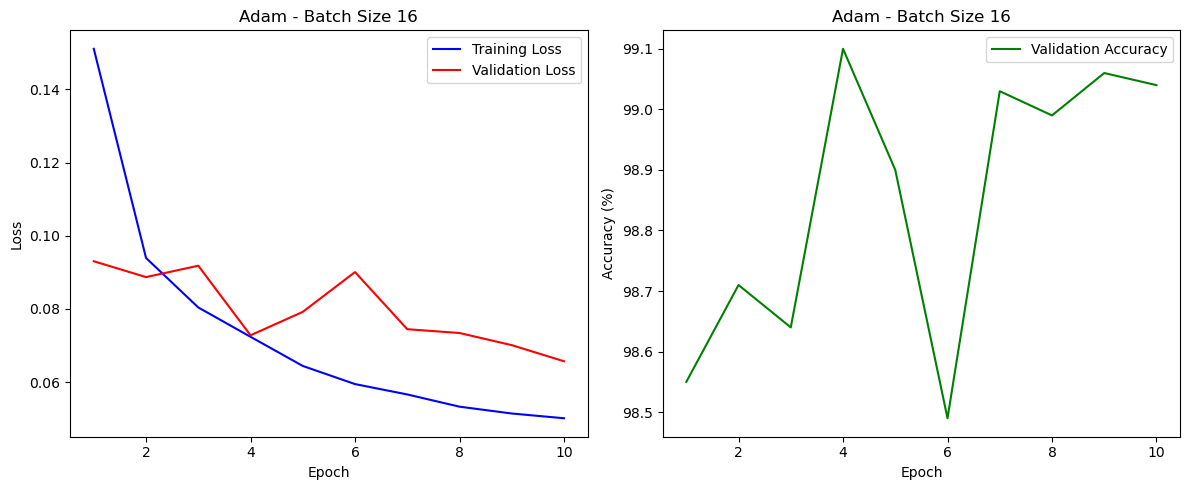

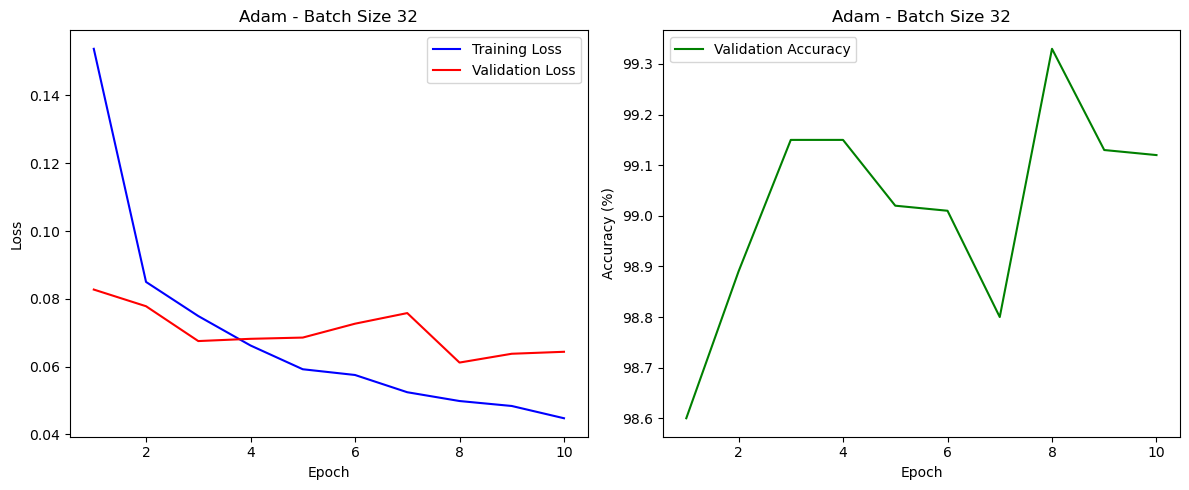

In [22]:
print("\nPlotting Results for Momentum Optimizer")
plot_results(momentum_results, "Momentum")

print("\nPlotting Results for Nesterov's Accelerated Gradient Optimizer")
plot_results(nag_results, "Nesterov's Accelerated Gradient")

print("\nPlotting Results for RMSprop Optimizer")
plot_results(rmsprop_results, "RMSprop")

print("\nPlotting Results for Adam Optimizer")
plot_results(adam_results, "Adam")


In [23]:
print("\nFinal Validation Accuracies:")

print("Momentum Optimizer:")
for batch_size in batch_sizes:
    acc = momentum_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")

print("\nNesterov's Accelerated Gradient Optimizer:")
for batch_size in batch_sizes:
    acc = nag_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")

print("\nRMSprop Optimizer:")
for batch_size in batch_sizes:
    acc = rmsprop_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")

print("\nAdam Optimizer:")
for batch_size in batch_sizes:
    acc = adam_results[batch_size]['val_accuracy'][-1]
    print(f"Batch Size {batch_size}: {acc:.2f}%")



Final Validation Accuracies:
Momentum Optimizer:
Batch Size 4: 99.14%
Batch Size 8: 98.97%
Batch Size 16: 98.94%
Batch Size 32: 98.85%

Nesterov's Accelerated Gradient Optimizer:
Batch Size 4: 10.10%
Batch Size 8: 93.98%
Batch Size 16: 97.63%
Batch Size 32: 98.96%

RMSprop Optimizer:
Batch Size 4: 98.61%
Batch Size 8: 98.67%
Batch Size 16: 98.85%
Batch Size 32: 99.13%

Adam Optimizer:
Batch Size 4: 98.76%
Batch Size 8: 98.88%
Batch Size 16: 99.04%
Batch Size 32: 99.12%
